# Import reuired libabries

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.ensemble import RandomForestClassifier


# Load Dataset

In [27]:
path = r"D:\STUDENT_CAREER\data\raw\CareerMapping1.csv"

df_raw = pd.read_csv(path)
df = df_raw.copy()
df.head()


,Unnamed: 0,Computer Architecture,Programming Skills,Project Management,Communication skills,Openness,Conscientousness,Extraversion,Agreeableness,Emotional_Range,Conversation,Openness to Change,Hedonism,Self-enhancement,Self-transcendence,Role
0,0,4.0,4.0,4.0,4.0,0.714603,0.480564,0.470877,0.039611,0.742567,0.086927,0.339776,0.091158,0.230518,0.208746,Database Administrator
1,1,5.0,4.0,4.0,4.0,0.617218,0.452903,0.377581,0.090148,0.672546,0.071425,0.353678,0.104495,0.247432,0.196424,Database Administrator
2,2,1.0,4.0,4.0,4.0,0.814072,0.461668,0.347739,0.138575,0.630705,0.095261,0.375125,0.135462,0.287253,0.268024,Database Administrator
3,3,0.0,4.0,4.0,4.0,0.607495,0.521783,0.403756,0.114925,0.695280,0.122656,0.338899,0.161705,0.306562,0.258119,Database Administrator
4,4,3.0,4.0,4.0,4.0,0.781293,0.319539,0.240337,0.050988,0.619390,0.065564,0.311896,0.147700,0.302978,0.207287,Database Administrator


In [28]:
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])


# Check overal dataset 

In [29]:
df.shape

(10179, 15)

In [30]:
# Check missing values
df.isnull().sum()


Computer Architecture    0
Programming Skills       0
Project Management       0
Communication skills     0
Openness                 0
Conscientousness         0
Extraversion             0
Agreeableness            0
Emotional_Range          0
Conversation             0
Openness to Change       0
Hedonism                 0
Self-enhancement         0
Self-transcendence       0
Role                     0
dtype: int64

In [31]:
print("Duplicates before:", df.duplicated().sum())

df = df.drop_duplicates(keep="first")

print("Duplicates after:", df.duplicated().sum())



Duplicates before: 6063
Duplicates after: 0


In [32]:
df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)


In [33]:
numeric_cols = [c for c in df.columns if c != "Role"]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")


In [8]:
# Chuyển đổi tất cả các cột có kiểu dữ liệu số
df = df.apply(pd.to_numeric, errors='coerce')  # "coerce" sẽ chuyển đổi các giá trị không thể thành số thành NaN


In [34]:
print(df["Role"].head())
print(df["Role"].dtype)


0    Database Administrator
1    Database Administrator
2    Database Administrator
3    Database Administrator
4    Database Administrator
Name: Role, dtype: object
object


In [36]:
# Tạo bản sạch để phân tích
df_clean = df.copy()


In [38]:
# Check outliers
def count_outliers(s):
    Q1, Q3 = s.quantile(0.25), s.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    return ((s < lower) | (s > upper)).sum()

print("Outliers in each column:")
for col in df.columns:
    if df[col].dtype != "object":
        print(f"- {col}: {count_outliers(df[col])}")



Outliers in each column:
- Computer Architecture: 0
- Programming Skills: 0
- Project Management: 0
- Communication skills: 0
- Openness: 426
- Conscientousness: 105
- Extraversion: 24
- Agreeableness: 362
- Emotional_Range: 316
- Conversation: 585
- Openness to Change: 623
- Hedonism: 600
- Self-enhancement: 608
- Self-transcendence: 707


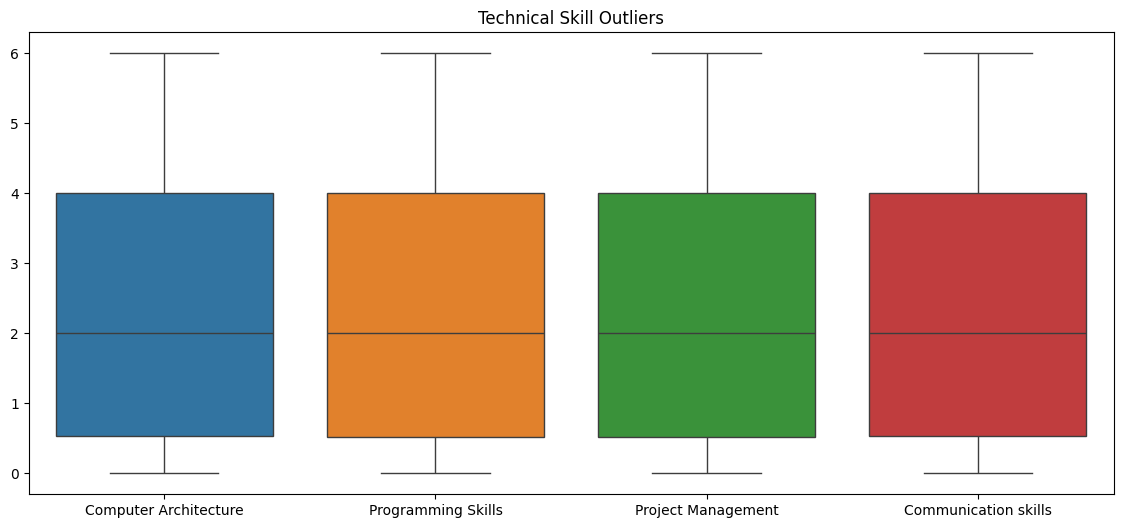

In [39]:
technical_cols = [
    "Computer Architecture",
    "Programming Skills",
    "Project Management",
    "Communication skills"
]

plt.figure(figsize=(14,6))
sns.boxplot(data=df[technical_cols])
plt.xticks(rotation=0)   # để nhãn nằm ngang
plt.title("Technical Skill Outliers")
plt.show()



# Encode Role → Role_encoded

In [55]:
encoder = LabelEncoder()
df_clean["Role_encoded"] = encoder.fit_transform(df_clean["Role"])

mapping = pd.DataFrame({
    "Role": encoder.classes_,
    "Encoded": range(len(encoder.classes_))
})

mapping.to_csv(r"D:\STUDENT_CAREER\data\cleaned\role_label_mapping1.csv", index=False)


# Distribution of Technical Skills

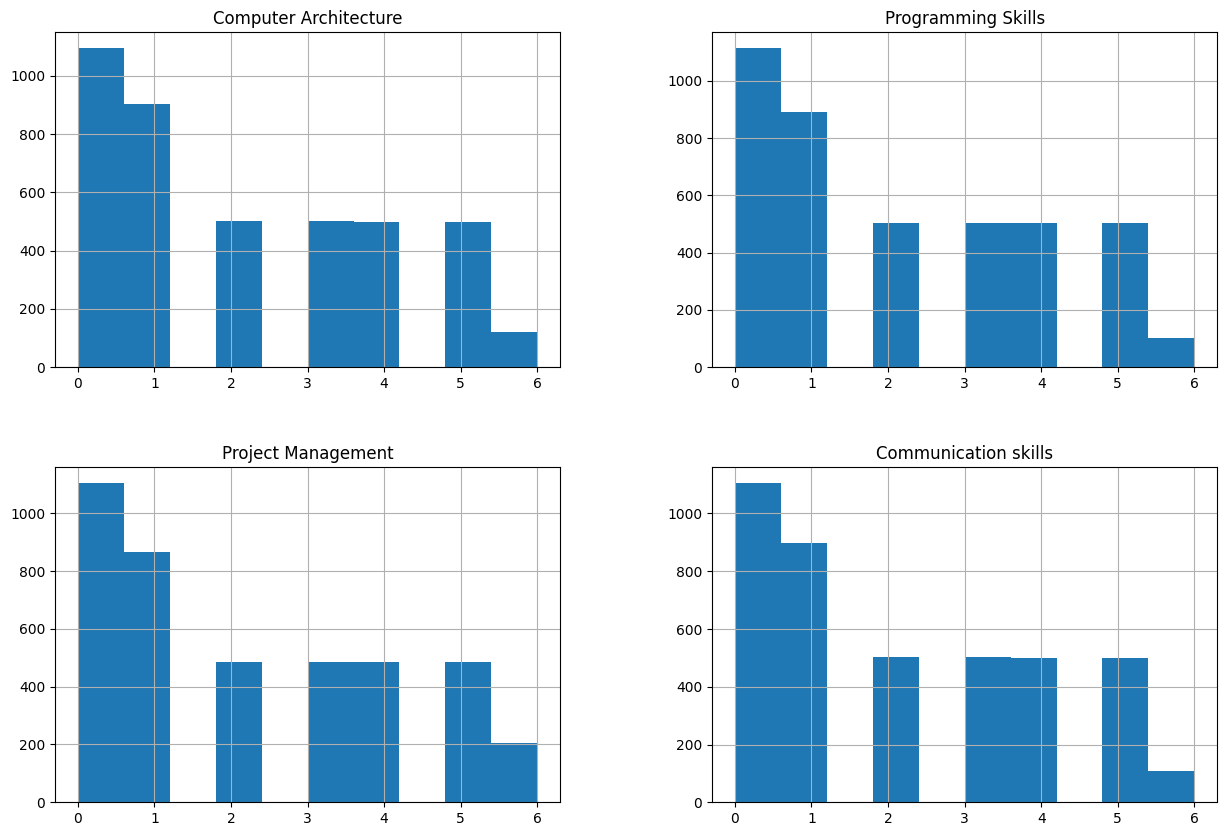

In [43]:
df[technical_cols].hist(figsize=(15,10), bins=10)
plt.show()


# Compute tech_score & soft_skill_score

In [46]:
soft_cols = [
    "Openness",
    "Conscientousness",
    "Extraversion",
    "Agreeableness",
    "Emotional_Range",
    "Conversation",
    "Openness to Change",
    "Hedonism",
    "Self-enhancement",
    "Self-transcendence"
]

df_clean["soft_skill_score"] = df_clean[soft_cols].mean(axis=1)
df_clean["tech_score"] = df_clean[technical_cols].mean(axis=1)


# Correlation Heatmap


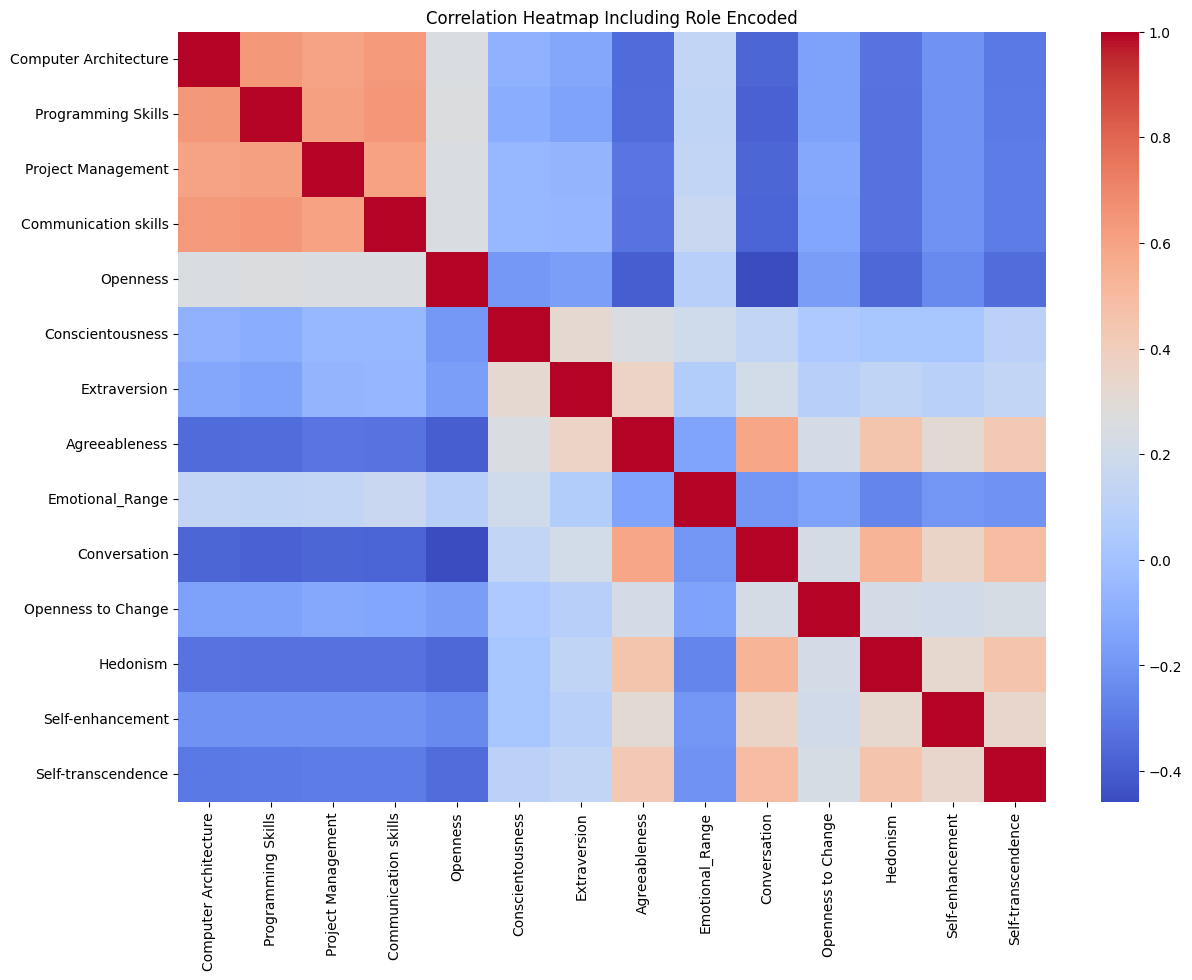

In [47]:
numeric_df = df.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(14,10))
sns.heatmap(numeric_df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap Including Role Encoded")
plt.show()


Heatmap cho thấy các nhóm kỹ năng có cấu trúc rõ rệt: kỹ năng kỹ thuật tương quan mạnh với nhau, kỹ năng mềm cũng tương quan mạnh trong nội bộ nhóm. Tech_score và soft_skill_score phản ánh đúng bản chất dữ liệu, cho thấy đây là hai đặc trưng tổng hợp hữu ích. Role (đã mã hóa) có tương quan nhẹ với nhiều kỹ năng, chứng tỏ việc dự đoán nghề nghiệp cần kết hợp cả kỹ năng cứng và kỹ năng mềm, phù hợp với mục tiêu mô hình phân loại nghề nghiệp

# Feature Importance (Random Forest)

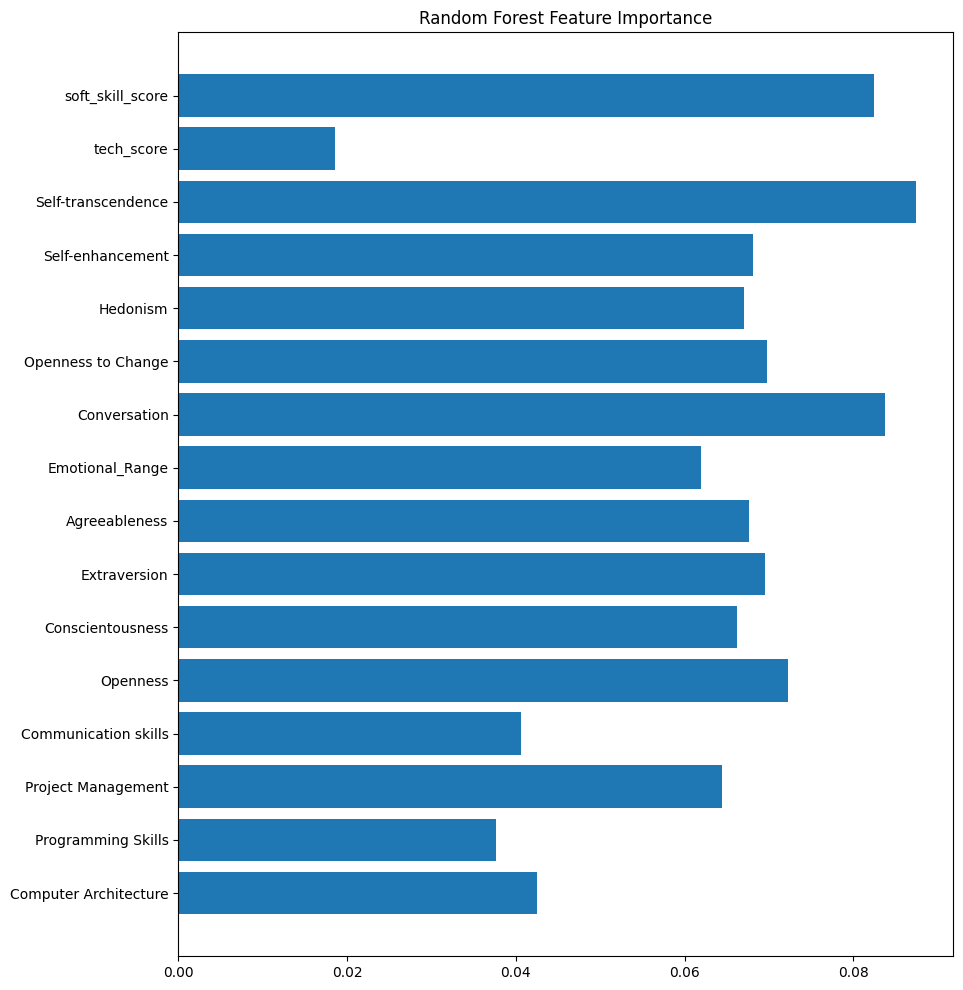

In [48]:
X = df_clean.drop(columns=["Role", "Role_encoded"])
y = df_clean["Role_encoded"]

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_

plt.figure(figsize=(10,12))
plt.barh(X.columns, importances)
plt.title("Random Forest Feature Importance")
plt.show()


Mô hình Random Forest cho thấy soft skills có tác động lớn hơn technical skills trong việc phân loại nghề nghiệp. Điều này cho thấy các nghề trong dataset phân hóa chủ yếu dựa trên hành vi, tính cách và xu hướng cá nhân của người học, hơn là sự khác biệt lớn trong kỹ năng kỹ thuật

# ANOVA + Mutual Information

In [53]:
f_scores, p_vals = f_classif(X, y)
mi_scores = mutual_info_classif(X, y)

anova_df = pd.DataFrame({"Feature": X.columns, "F-Score": f_scores, "p-Value": p_vals})
mi_df = pd.DataFrame({"Feature": X.columns, "MI Score": mi_scores})

anova_df.sort_values(by="F-Score", ascending=False, inplace=True)
mi_df.sort_values(by="MI Score", ascending=False, inplace=True)


C:\Users\Phuoc Di\AppData\Local\Temp\ipykernel_18364\835500836.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F-Score", y="Feature", data=anova_df, palette="viridis")


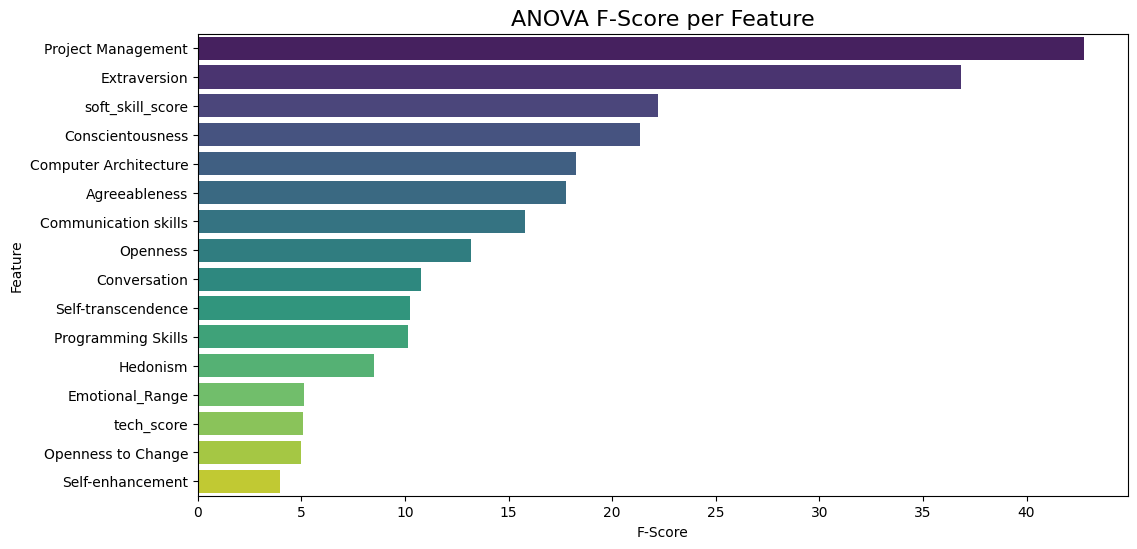

In [54]:
plt.figure(figsize=(12,6))
sns.barplot(x="F-Score", y="Feature", data=anova_df, palette="viridis")
plt.title("ANOVA F-Score per Feature", fontsize=16)
plt.xlabel("F-Score")
plt.ylabel("Feature")
plt.show()


Soft skills là yếu tố chính dự đoán nghề nghiệp trong CareerMapping1.csv.

Technical skills hầu như không tạo khác biệt giữa các Role.

Mô hình dự đoán sẽ mạnh hơn nếu ưu tiên các soft features + soft_skill_score

# Mean Skill per Role

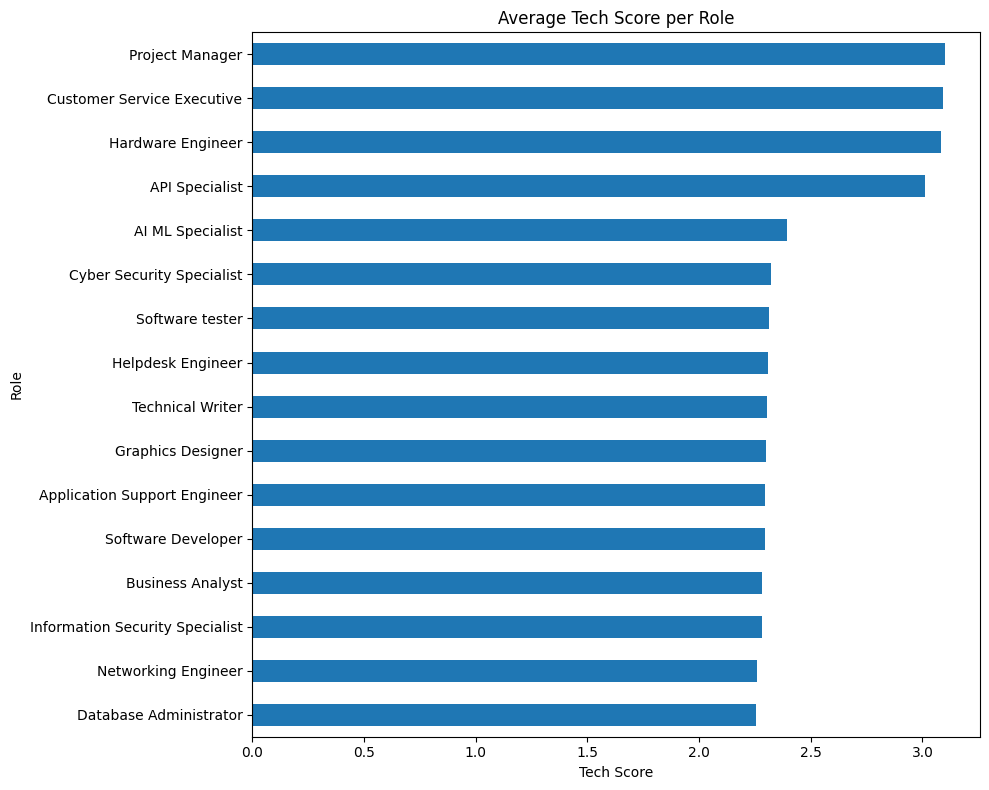

In [33]:
plt.figure(figsize=(10, 8))
df.groupby("Role")["tech_score"].mean().sort_values().plot(kind="barh")

plt.title("Average Tech Score per Role")
plt.xlabel("Tech Score")
plt.ylabel("Role")
plt.tight_layout()
plt.show()


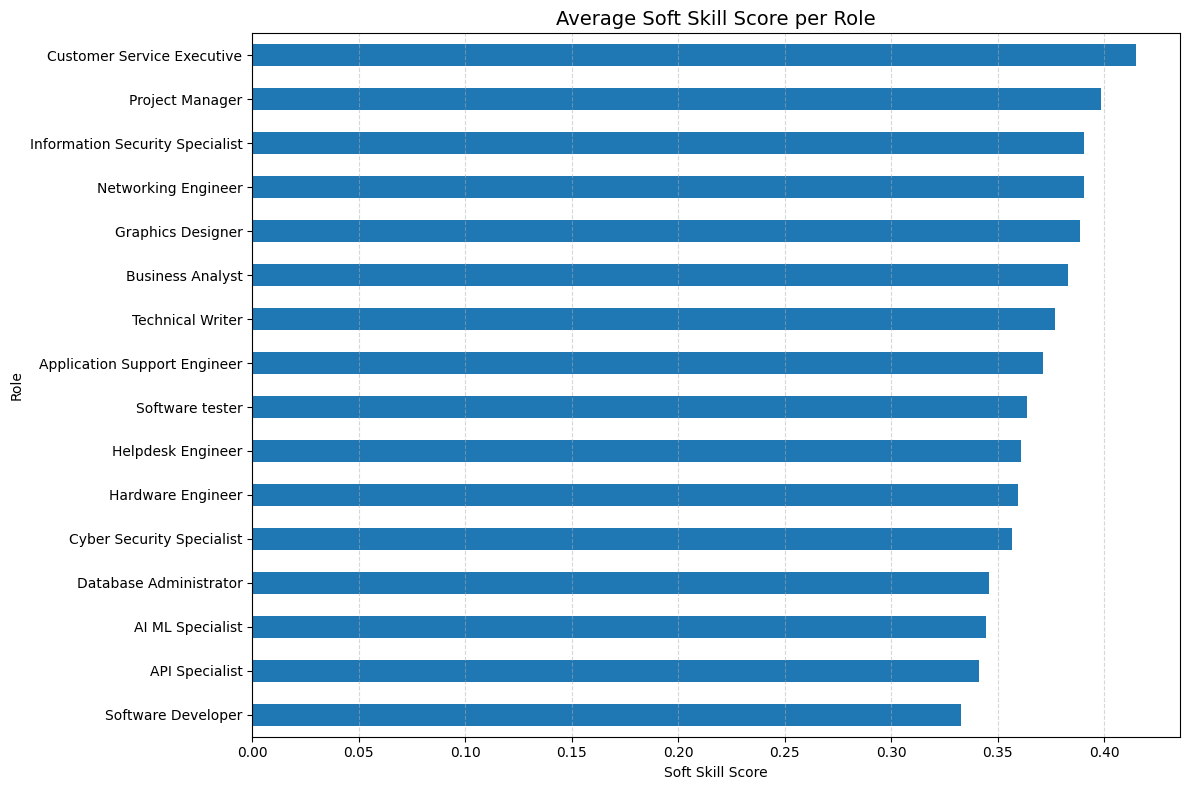

In [34]:
plt.figure(figsize=(12, 8))
df.groupby("Role")["soft_skill_score"] \
    .mean() \
    .sort_values() \
    .plot(kind="barh")

plt.title("Average Soft Skill Score per Role", fontsize=14)
plt.xlabel("Soft Skill Score")
plt.ylabel("Role")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Export Processed RAW File

In [57]:
raw_out = r"D:\STUDENT_CAREER\data\cleaned\processed_raw_CareerMapping1.csv"
df_clean.to_csv(raw_out, index=False)


# Export Raw with Scores

In [58]:
raw_score_out = r"D:\STUDENT_CAREER\data\cleaned\processed_raw_CareerMapping1_with_scores.csv"
df_clean.to_csv(raw_score_out, index=False)


# Export Scaled Version

In [59]:
cols_to_scale = [col for col in df_clean.columns if col not in ["Role", "Role_encoded"]]

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_clean[cols_to_scale])

df_scaled = pd.DataFrame(scaled_values, columns=cols_to_scale)
df_scaled["Role_encoded"] = df_clean["Role_encoded"]

scaled_out = r"D:\STUDENT_CAREER\data\cleaned\scaled_CareerMapping1_with_scores.csv"
df_scaled.to_csv(scaled_out, index=False)
